In [1]:
from joblib import load
import numpy as np
import pandas as pd

# fetch training data (thank you keegan)
df = load('../DL_data/results_dataframe/results_dataframe.pkl')
print(type(df))
print(f'DF {df.shape}')
print(df.columns)

def normalize_P(df):
    def norm(x):
        x = np.array(x, dtype=np.float32)
        return ((x - -100) / (100 - -100)) * 2 - 1
    return df['P'].apply(lambda x: norm(x).tolist())
df['P'] = normalize_P(df)
print(df.head())

<class 'pandas.core.frame.DataFrame'>
DF (10980480, 5)
Index(['n', 'k', 'm', 'result', 'P'], dtype='object')
    n  k  m       result                                                  P
0  10  5  2   266.264524  [-0.533016562461853, 0.46367478370666504, 0.12...
1   9  4  2   140.163560  [0.06517887115478516, -0.06281203031539917, 0....
2  10  4  3   167.692765  [-0.6702930331230164, 0.8295217752456665, -0.0...
3   9  4  3   565.010999  [0.9114111661911011, -0.15260308980941772, -0....
4   9  6  2  1170.076493  [0.9283944368362427, -0.9782330989837646, 0.05...


Using device: cuda
n:10, k:5
num_train_samples: 650000 num_val_samples: 250000 num_test_samples: 100000
Epoch 1/30: train loss 22.4000, val loss 11.4586
Best model saved at epoch 1 with val loss: 11.4586
Epoch 2/30: train loss 10.4820, val loss 7.9386
Best model saved at epoch 2 with val loss: 7.9386
Epoch 3/30: train loss 6.0098, val loss 4.6069
Best model saved at epoch 3 with val loss: 4.6069
Epoch 4/30: train loss 7.3786, val loss 6.1501
Epoch 5/30: train loss 9.5124, val loss 7.2192
Epoch 6/30: train loss 9.6879, val loss 6.8012
Epoch 7/30: train loss 8.6994, val loss 5.0164
Epoch 8/30: train loss 7.0402, val loss 6.4806
terminating training


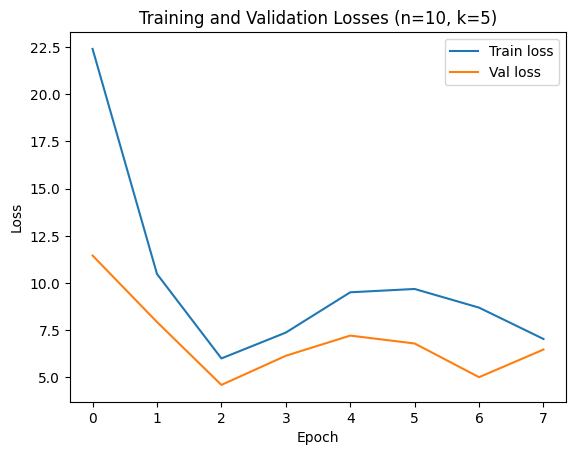

Test Ratio Loss: 6.507372


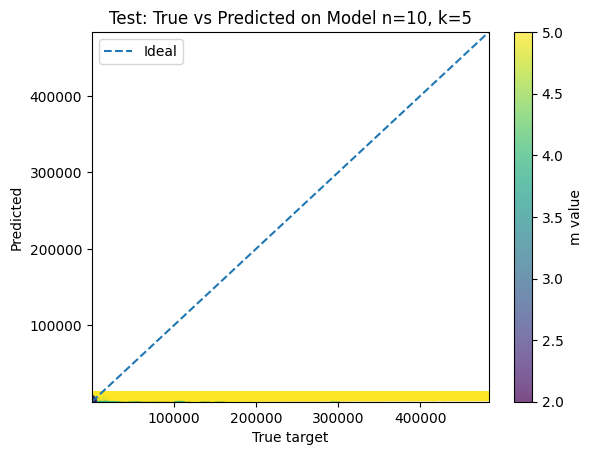

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt
import math

class RowTokenDataset(Dataset):
    def __init__(self, df, n, k):
        self.n = n
        self.k = k
        self.m = df['m'].astype(int).values
        self.P = df['P'].apply(lambda s: torch.tensor(s, dtype=torch.float32))
        # self.Pt = df['P'].apply(lambda s: torch.tensor(s, dtype=torch.float32).transpose(0, 1))
        self.y = torch.tensor(df['result'].values, dtype=torch.float32)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        # Retrieve the tensor P
        P_val = self.P.iloc[idx].view(self.k, self.n - self.k)
        target = self.y[idx]
        
        # Create an m token that has the same dimension as a row in P.
        token_dim = P_val.size(1)  # expected token dim = n-k
        m_token = torch.full((1, token_dim), self.m[idx], dtype=torch.float32)
        
        # Combine the tokens: place the m token at the start.
        tokens = torch.cat([m_token, P_val], dim=0)  # shape: (k+1, n-k)
        return tokens, target

def process_P(s, k, n):
    t = torch.tensor(s, dtype=torch.float32)
    if t.dim() == 1:
        t = t.view(k, n - k)
    return t.transpose(0, 1)

class ColTokenDataset(Dataset):
    def __init__(self, df, n, k):
        self.n = n
        self.k = k
        self.m = df['m'].astype(int).values
        self.Pt = df['P'].apply(lambda s: process_P(s, k, n))
        self.y = torch.tensor(df['result'].values, dtype=torch.float32)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        # Retrieve the tensor P
        Pt_val = self.Pt.iloc[idx].view(self.n - self.k, self.k)
        target = self.y[idx]
        
        # Create an m token that has the same dimension as a row in P.
        token_dim = Pt_val.size(1)  # expected token dim = n-k
        m_token = torch.full((1, token_dim), self.m[idx], dtype=torch.float32)
        
        # Combine the tokens: place the m token at the start.
        tokens = torch.cat([m_token, Pt_val], dim=0)  # shape: (k+1, n-k)
        return tokens, target

class RowColTokenDataset(Dataset):
    def __init__(self, df, n, k):
        self.n = n
        self.k = k
        self.m = df['m'].astype(int).values
        self.P = df['P'].apply(lambda s: torch.tensor(s, dtype=torch.float32))
        self.Pt = df['P'].apply(lambda s: process_P(s, k, n))

        # Optional target
        self.has_targets = 'result' in df.columns
        if self.has_targets:
            self.y = torch.tensor(df['result'].values, dtype=torch.float32)

        if k < (n - k):
            self.pad_col = (0, (n - k) - k)
            self.pad_row = None
        elif k > (n - k):
            self.pad_row = (0, k - (n - k))
            self.pad_col = None
        else:
            self.pad_row = None
            self.pad_col = None

    def __len__(self):
        return len(self.m)

    def __getitem__(self, idx):
        P_val = self.P.iloc[idx].view(self.k, self.n - self.k)
        Pt_val = self.Pt.iloc[idx].view(self.n - self.k, self.k)

        if self.pad_row:
            P_val = F.pad(P_val, self.pad_row, mode='constant', value=0)
        if self.pad_col:
            Pt_val = F.pad(Pt_val, self.pad_col, mode='constant', value=0)

        token_dim = max(self.k, self.n - self.k)
        m_token = torch.full((1, token_dim), self.m[idx], dtype=torch.float32)
        tokens = torch.cat([m_token, P_val, Pt_val], dim=0)

        if self.has_targets:
            return tokens, self.y[idx]
        else:
            return tokens, torch.tensor(0.0)

# Positional encoding module from "Attention is All You Need"
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)  # (1, max_len, d_model)
        self.register_buffer('pe', pe)
    
    def forward(self, x):
        # x shape: (batch_size, seq_len, d_model)
        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)

# Transformer model for regression
class TransformerRegression(nn.Module):
    def __init__(self, token_dim, d_model, nhead, num_layers, dim_feedforward, n, k, dropout=0.1):
        """
        token_dim: Dimension of each token (n-k from your dataset)
        d_model: Embedding dimension for the transformer
        nhead: Number of attention heads
        num_layers: Number of transformer encoder layers
        dim_feedforward: Dimension of the feed-forward network inside the transformer
        dropout: Dropout rate
        """
        super().__init__()
        self.n = n; self.k = k
        # Project input tokens (of dimension token_dim) to d_model dimension.
        self.input_projection = nn.Linear(token_dim, d_model)
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout, batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        # For regression, we can aggregate transformer outputs.
        # Here, we use mean pooling across the sequence.
        self.regressor = nn.Sequential(
            nn.Linear(d_model, d_model//2),
            nn.ReLU(),
            nn.Linear(d_model//2, 1)
        )
    
    def forward(self, x):
        """
        x shape: (batch_size, seq_len, token_dim)
        """
        # Project the tokens into embedding space.
        x = self.input_projection(x)  # (batch_size, seq_len, d_model)
        x = self.pos_encoder(x)
        
        # Transformer expects shape (seq_len, batch_size, d_model)
        x = x.transpose(0, 1)
        x = self.transformer_encoder(x)
        x = x.transpose(0, 1)  # back to (batch_size, seq_len, d_model)
        
        # Mean pool over the sequence dimension
        pooled = x.mean(dim=1)
        output = self.regressor(pooled)
        return output

def ratio_loss(preds, targets, eps=1e-6):
    preds = torch.clamp(preds, min=eps)
    targets = torch.clamp(targets, min=eps)
    return torch.mean((torch.log2(targets) - torch.log2(preds))**2)
criterion = ratio_loss

def train(model, train_loader, val_loader):
    train_losses, val_losses = [], []
    best_val_loss = float('inf')
    best_model_state = None
    no_improve_epochs = 0
    for epoch in range(EPOCHS):
        model.train()
        running_loss = 0
        for tokens, target in train_loader:
            tokens, target = tokens.to(device), target.to(device).unsqueeze(1)
            optimizer.zero_grad()
            preds = model(tokens)
            loss = criterion(preds, target)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * tokens.size(0)
        train_loss = running_loss / len(train_loader.dataset)
        
        # Evaluate on validation set
        model.eval()
        running_val_loss = 0.0
        with torch.no_grad():
            for tokens, target in val_loader:
                tokens, target = tokens.to(device), target.to(device).unsqueeze(1)
                preds = model(tokens)
                loss = criterion(preds, target)
                running_val_loss += loss.item() * tokens.size(0)
        val_loss = running_val_loss / len(val_loader.dataset)
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        print(f"Epoch {epoch+1}/{EPOCHS}: train loss {train_loss:.4f}, val loss {val_loss:.4f}")

        # Save model if validation loss improves
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict()
            torch.save(best_model_state, f"model-tt{model.n}_{model.k}.pt")
            print(f"Best model saved at epoch {epoch+1} with val loss: {best_val_loss:.4f}")
            no_improve_epochs = 0
        else: no_improve_epochs+=1

        if no_improve_epochs > 4: print('terminating training'); break

    # Plot losses
    plt.figure()
    plt.plot(train_losses, label="Train loss")
    plt.plot(val_losses, label="Val loss")
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend()
    plt.title(f"Training and Validation Losses (n={model.n}, k={model.k})")
    plt.show()

    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    return model


def test_and_plot(model, test_loader):
    model.eval()

    all_preds, all_targets, all_m = [], [], []
    total_loss = 0
    criterion = ratio_loss

    with torch.no_grad():
        for tokens, target in test_loader:
            # tokens shape: (batch, seq_len, token_dim)
            tokens = tokens.to(device)
            target = target.to(device).unsqueeze(1)
            preds = model(tokens).reshape(-1)
            loss = criterion(preds, target.reshape(-1))
            total_loss += loss.item() * tokens.size(0)
            all_preds.append(preds.cpu())
            all_targets.append(target.cpu().reshape(-1))
            # Extract m values from the first token.
            # Assume the m token is the first row of each sample and each token is a constant vector.
            # We can take the first element as representative.
            m_batch = tokens[:, 0, 0]  # shape: (batch,)
            all_m.append(m_batch.cpu())

    all_preds = torch.cat(all_preds).numpy()
    all_targets = torch.cat(all_targets).numpy()
    all_m = torch.cat(all_m).numpy()

    loss = total_loss / len(test_loader.dataset)
    print(f"Test Ratio Loss: {loss:.6f}")

    # graph bounds
    combined = np.concatenate([all_targets, all_preds])
    low, high = np.percentile(combined, [0, 99])

    plt.figure()
    sc = plt.scatter(all_targets, all_preds, c=all_m, cmap='viridis', alpha=0.7)
    plt.plot([low, high], [low, high], linestyle='--', label='Ideal')
    plt.xlim(low, high); plt.ylim(low, high)
    plt.xlabel("True target"); plt.ylabel("Predicted")
    plt.colorbar(sc, label='m value'); plt.legend()
    plt.title(f"Test: True vs Predicted on Model n={model.n}, k={model.k}")
    plt.show()

def set_seed(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


set_seed(242)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
BATCH_SIZE = 64
EPOCHS = 30
for n,k in [(10,5)]:
    if device.type == "cuda":
        data = df[(df['n'] == n) & (df['k'] == k)].head(1000000)
    else: # <3 laptop
        data = df[(df['n'] == n) & (df['k'] == k)].head(200000)
    num_train_samples = int(0.65 * len(data))
    num_val_samples = int(0.25 * len(data))
    num_test_samples = len(data) - num_train_samples - num_val_samples
    print(f'n:{n}, k:{k}')
    print("num_train_samples:", num_train_samples,"num_val_samples:", num_val_samples,"num_test_samples:", num_test_samples)
    dataset = RowColTokenDataset(data, n, k)
    train_data, val_data, test_data = random_split(dataset, [num_train_samples, num_val_samples, num_test_samples])
    train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True)
    if dataset.__class__.__name__ == 'RowTokenDataset': token_dim = n-k
    elif dataset.__class__.__name__ == 'ColTokenDataset': token_dim = k
    else: token_dim = max(k, n - k)
    model = TransformerRegression(token_dim, d_model=128, nhead=8, num_layers=4, dim_feedforward=128, dropout=0.1, n=n, k=k).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
    model = train(model, train_loader, val_loader)
    test_and_plot(model, test_loader)
    # break


In [33]:
model_configs = {
    (9, 4): {"nhead": 8, "num_layers": 8},
    (9, 5): {"nhead": 8, "num_layers": 8},
    (9, 6): {"nhead": 8, "num_layers": 8},
    (10, 4): {"nhead": 8, "num_layers": 6},
    (10, 5): {"nhead": 8, "num_layers": 4},
    (10, 6): {"nhead": 16, "num_layers": 4},
}

def load_models(model_configs):
    models = {}
    for (n, k), config in model_configs.items():
        token_dim = max(k, n-k)
        model = TransformerRegression(token_dim=token_dim, d_model=128,
                            nhead=config["nhead"],
                            num_layers=config["num_layers"],
                            dim_feedforward=128, dropout=0.1,
                            n=n, k=k)
        try:
            model.load_state_dict(torch.load(f"model-t{n}_{k}.pt", map_location=device))
            model.to(device)
            model.eval()
            models[(n, k)] = model
            print(f"Loaded (n={n}, k={k}) with config: {config}")
        except FileNotFoundError:
            print(f"Model not found for (n={n}, k={k})")
    return models

models = load_models(model_configs)


Loaded (n=9, k=4) with config: {'nhead': 8, 'num_layers': 8}
Loaded (n=9, k=5) with config: {'nhead': 8, 'num_layers': 8}
Loaded (n=9, k=6) with config: {'nhead': 8, 'num_layers': 8}
Loaded (n=10, k=4) with config: {'nhead': 8, 'num_layers': 6}
Loaded (n=10, k=5) with config: {'nhead': 8, 'num_layers': 4}
Loaded (n=10, k=6) with config: {'nhead': 16, 'num_layers': 4}


Predicting for n=9, k=4, m=2
Test Ratio Loss: 40.135623


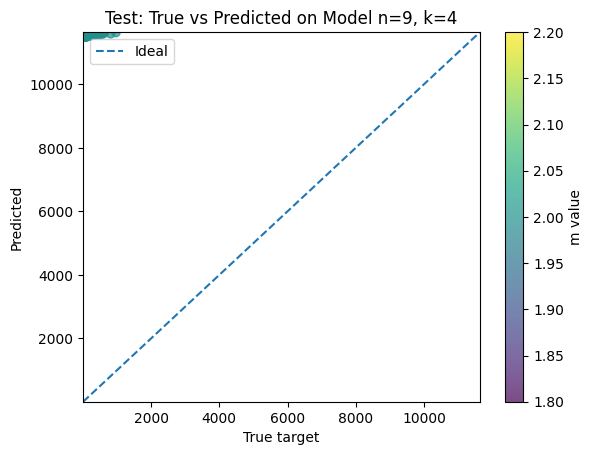

Predicting for n=9, k=4, m=3
Test Ratio Loss: 29.558350


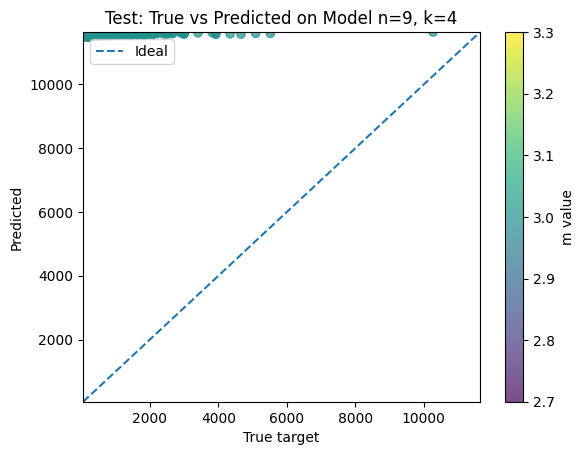

Predicting for n=9, k=4, m=4
Test Ratio Loss: 13.848277


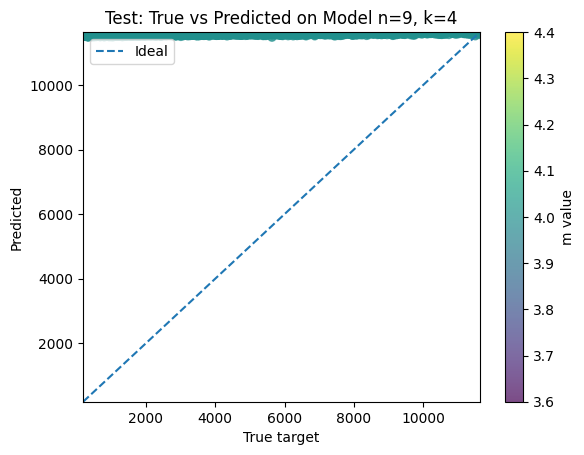

Predicting for n=9, k=5, m=2
Test Ratio Loss: 32.631932


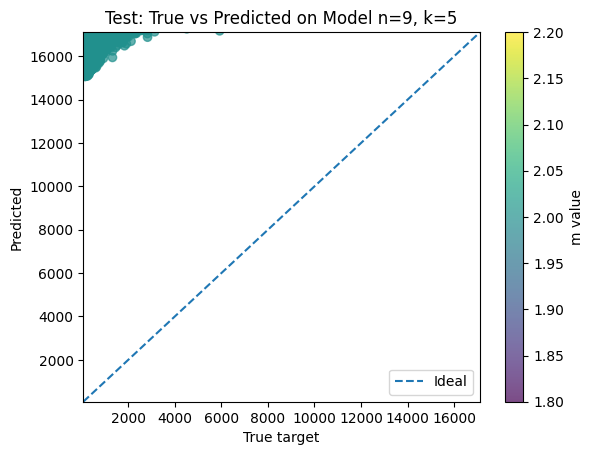

Predicting for n=9, k=5, m=3


KeyboardInterrupt: 

Exception ignored in: 'zmq.backend.cython._zmq.Frame.__del__'
Traceback (most recent call last):
  File "_zmq.py", line 160, in zmq.backend.cython._zmq._check_rc
KeyboardInterrupt: 
Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x000001D43C251160>>
Traceback (most recent call last):
  File "c:\Users\nick2\anaconda3\envs\DL\Lib\site-packages\ipykernel\ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


Test Ratio Loss: 15.876455


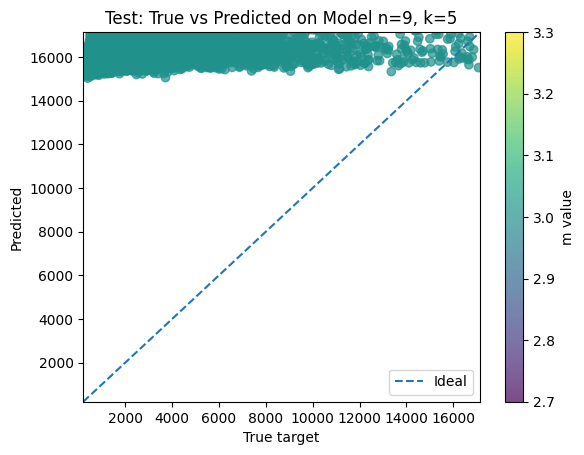

Predicting for n=9, k=6, m=2
Test Ratio Loss: 14.079126


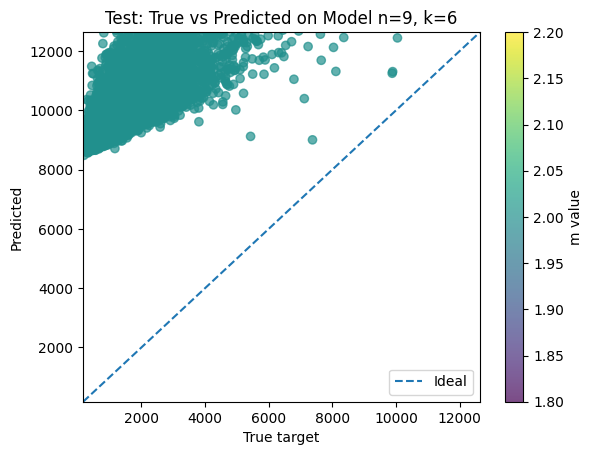

Predicting for n=10, k=4, m=2
Test Ratio Loss: 11.986514


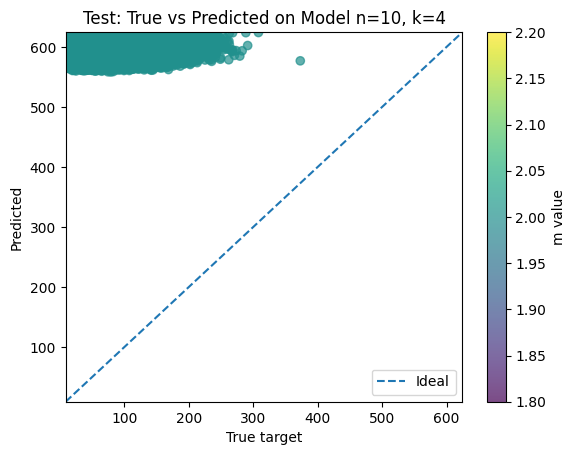

Predicting for n=10, k=4, m=3
Test Ratio Loss: 2.976764


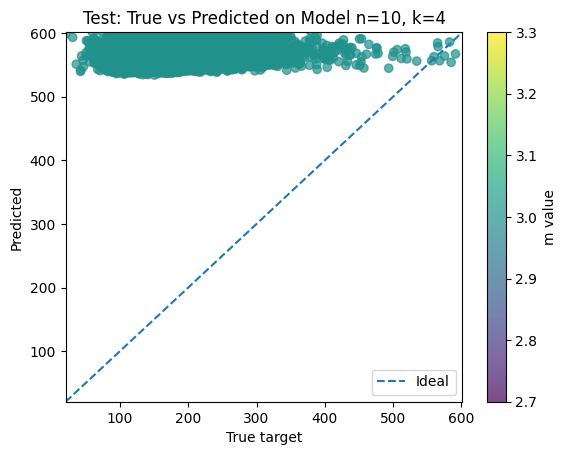

Predicting for n=10, k=4, m=4
Test Ratio Loss: 19.628300


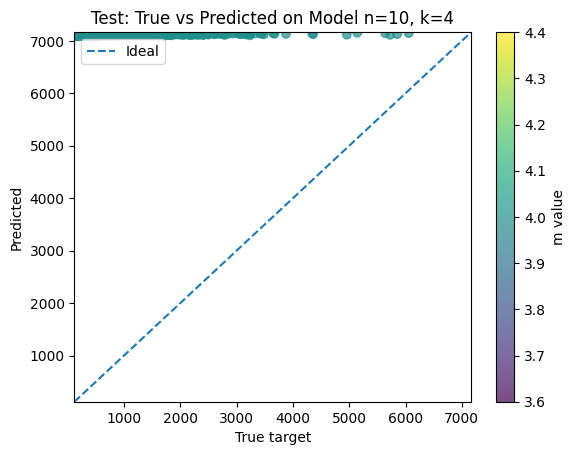

Predicting for n=10, k=4, m=5
Test Ratio Loss: 20.861976


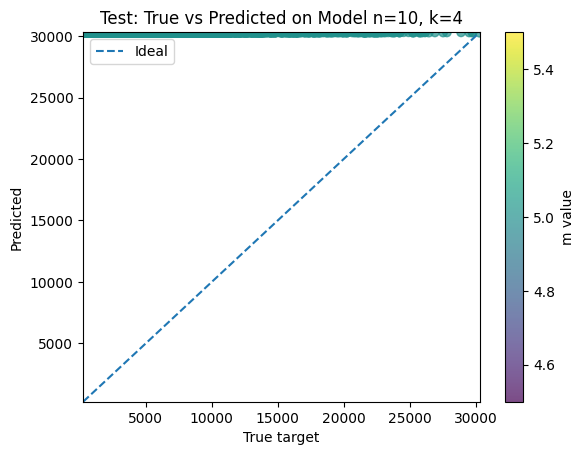

Predicting for n=10, k=5, m=2
Test Ratio Loss: 13.036259


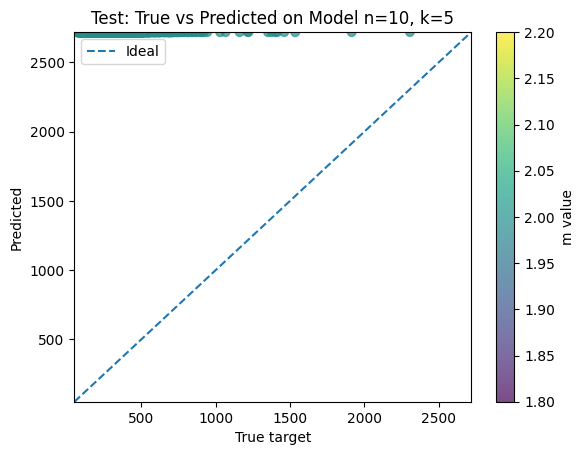

Predicting for n=10, k=5, m=3
Test Ratio Loss: 8.372972


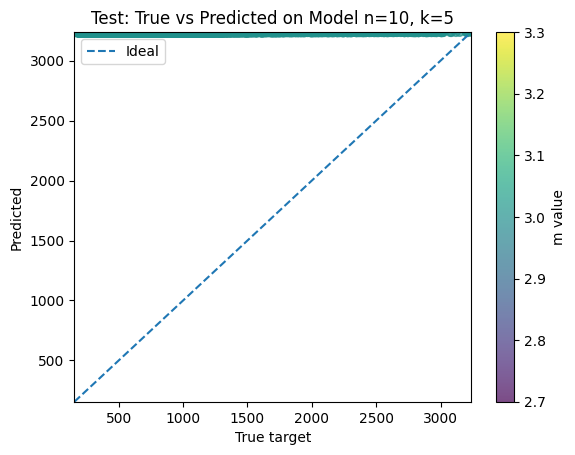

Predicting for n=10, k=5, m=4
Test Ratio Loss: 0.938613


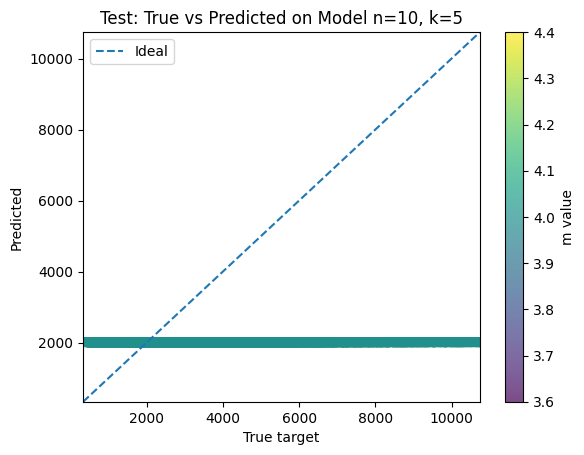

Predicting for n=10, k=6, m=2
Test Ratio Loss: 14.607271


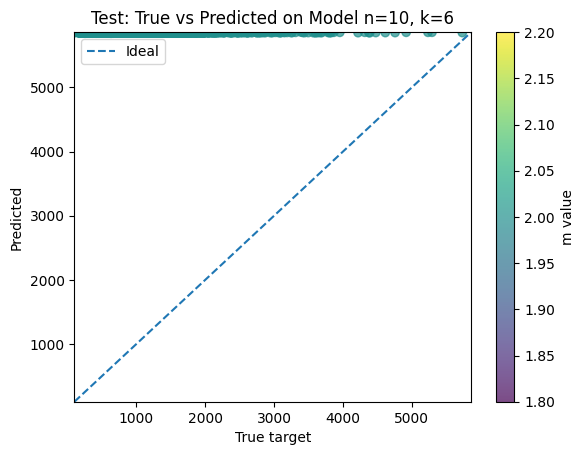

Predicting for n=10, k=6, m=3
Test Ratio Loss: 4.238661


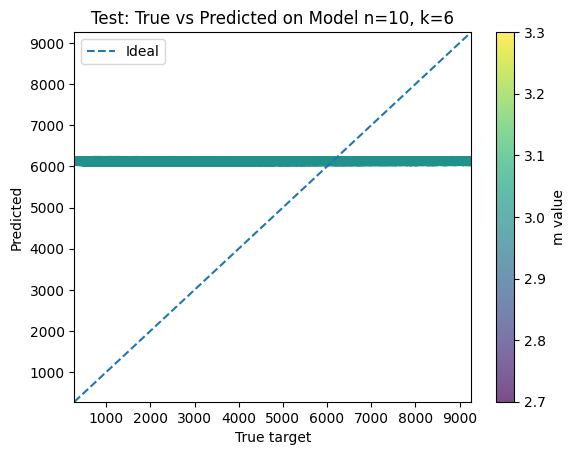

In [ ]:
def predict_P_batch(n, k, m, df_test, models, batch_size=64):
    key = (n, k)
    model = models.get(key)
    if model is None:
        raise ValueError(f"No model found for (n={n}, k={k})")

    dataset = RowColTokenDataset(df_test, n=n, k=k)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    test_and_plot(model, loader)

def build_rowcol_dataframe(P_list, m, n, k):
    """
    P_list: list of numpy matrices (shape [k, n-k] or flattenable to that)
    m: scalar or list of ints, same length as P_list
    n, k: integers describing structure of each P

    Returns:
        DataFrame with columns: P, m, n, k
    """
    if isinstance(m, int):
        m_values = [m] * len(P_list)
    elif isinstance(m, list) or isinstance(m, np.ndarray):
        if len(m) != len(P_list):
            raise ValueError("Length of m must match number of matrices in P_list")
        m_values = m
    else:
        raise TypeError("m must be an int or list/array of ints")

    df = pd.DataFrame({
        "P": P_list,
        "m": m_values,
        "n": [n] * len(P_list),
        "k": [k] * len(P_list),
    })

    return df

for n,k in [(9,4), (9,5), (9,6), (10,4), (10,5), (10,6)]:
    for m in list(range(n-k))[2:]:
        print(f"Predicting for n={n}, k={k}, m={m}")
        predict_P_batch(n, k, m, df[(df['n'] == n) & (df['k'] == k) & (df['m'] == m)].head(50000), models)


I spent 2 weeks training different models and the last 6 days on transformer models alone and these results are far worse than those I got during training. Testing at all m's rather than the ones available in the dataset would likely help a lot more and I know this for the next project. Unfortunately this is the best I can do for this submission.

In [ ]:
def build_rowcol_dataframe(n, k, m, p_list):
    """
    p_list: list of numpy matrices (shape [k, n-k] or flattenable to that)
    m: scalar or list of ints, same length as p_list
    n, k: integers describing structure of each P

    Returns:
        DataFrame with columns: P, m, n, k
    """
    if isinstance(m, int):
        m_values = [m] * len(p_list)
    elif isinstance(m, list) or isinstance(m, np.ndarray):
        if len(m) != len(p_list):
            raise ValueError("Length of m must match number of matrices in p_list")
        m_values = m
    else:
        raise TypeError("m must be an int or list/array of ints")

    df = pd.DataFrame({
        "P": p_list,
        "m": m_values,
    })

    return RowColTokenDataset(df, n, k)

def run_predictions(dataset, models, n, k, batch_size=BATCH_SIZE):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = models.get((n, k))
    if model is None:
        raise ValueError(f"No model found for (n={n}, k={k})")

    model.to(device)
    model.eval()
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    all_preds = []

    with torch.no_grad():
        for tokens, _ in loader:  # ignore targets
            tokens = tokens.to(device)
            preds = model(tokens).squeeze(1)
            all_preds.extend(preds.cpu().numpy().tolist())

    return all_preds